# Deepfake training + evaluation (subset pipeline)
# - Uses existing scripts in this folder
# - Steps: (1) optional subset prep, (2) MobileNetV2 train, (3) threshold calibration, (4) validation report, (5) quick image tests

In [2]:
!pip install mtcnn tensorflow opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.6 MB/s eta 0:00:00


In [3]:
import cv2
import numpy as np
import os
from mtcnn import MTCNN  # or use dlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
train_videos_path = '/content/drive/MyDrive/ dfdc_data/train_sample_videos'
test_videos_path = '/content/drive/MyDrive/ dfdc_data/test_videos'
submission_file_path = '/content/drive/MyDrive/ dfdc_data/sample_submission.csv'

In [7]:
import cv2
import os

def extract_frames_from_folder(folder_path, output_base):
    os.makedirs(output_base, exist_ok=True)  # Base output folder
    videos = os.listdir(folder_path)  # List all videos

    for video_name in videos:
        video_path = os.path.join(folder_path, video_name)
        output_folder = os.path.join(output_base, os.path.splitext(video_name)[0])  # Folder per video

        os.makedirs(output_folder, exist_ok=True)
        cap = cv2.VideoCapture(video_path)
        count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_path = os.path.join(output_folder, f"frame_{count}.jpg")
            cv2.imwrite(frame_path, frame)
            count += 1

        cap.release()
        print(f"Extracted {count} frames from {video_name}")

# Usage:
extract_frames_from_folder(train_videos_path, '/content/frames/train')



Extracted 300 frames from acxnxvbsxk.mp4
Extracted 300 frames from aczrgyricp.mp4
Extracted 300 frames from abqwwspghj.mp4
Extracted 300 frames from aagfhgtpmv.mp4
Extracted 300 frames from abofeumbvv.mp4
Extracted 298 frames from acxwigylke.mp4
Extracted 300 frames from adhsbajydo.mp4
Extracted 300 frames from aapnvogymq.mp4
Extracted 300 frames from acifjvzvpm.mp4
Extracted 300 frames from abarnvbtwb.mp4
Extracted 300 frames from acqfdwsrhi.mp4
Extracted 300 frames from adohikbdaz.mp4
Extracted 300 frames from agrmhtjdlk.mp4
Extracted 300 frames from aettqgevhz.mp4
Extracted 300 frames from ahdbuwqxit.mp4
Extracted 300 frames from ahqqqilsxt.mp4
Extracted 300 frames from ahfazfbntc.mp4
Extracted 300 frames from ahbweevwpv.mp4
Extracted 300 frames from agdkmztvby.mp4
Extracted 300 frames from agqphdxmwt.mp4
Extracted 300 frames from aevrfsexku.mp4
Extracted 300 frames from ajqslcypsw.mp4
Extracted 300 frames from afoovlsmtx.mp4
Extracted 300 frames from aipfdnwpoo.mp4
Extracted 300 fr

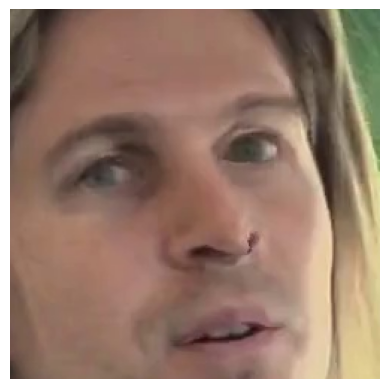

In [8]:
import cv2
import os
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def detect_and_crop_face(image_path, output_path=None):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face_img = img[y:y+h, x:x+w]
        if output_path:
            cv2.imwrite(output_path, face_img)
        return face_img  # return first face cropped

# Example usage:
image_path = '/content/frames/train/aagfhgtpmv/frame_0.jpg'  # ek extracted frame ka path
cropped_face = detect_and_crop_face(image_path, '/content/frames/train/aagfhgtpmv/face_0.jpg')
plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [11]:
import cv2
import os

# Load Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def detect_and_crop_faces_in_folder(frames_folder, output_base_folder, video_id):
    """
    Detects and crops faces from frames in a folder and saves them to a specified output base folder.

    Args:
        frames_folder (str): Path to the folder containing the frames for a single video.
        output_base_folder (str): Base path where the cropped faces will be saved.
        video_id (str): The ID of the video (used to create a subfolder in the output).
    """
    output_folder = os.path.join(output_base_folder, video_id)
    os.makedirs(output_folder, exist_ok=True)
    frames = os.listdir(frames_folder)

    for frame_name in frames:
        frame_path = os.path.join(frames_folder, frame_name)
        # Skip if not a file or if it's not a common image file extension
        if not os.path.isfile(frame_path) or not frame_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        img = cv2.imread(frame_path)
        # Check if the image was loaded successfully
        if img is None:
            print(f"Warning: Could not load image {frame_path}. Skipping.")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        for i, (x, y, w, h) in enumerate(faces):
            face_img = img[y:y+h, x:x+w]
            face_output_path = os.path.join(output_folder, f"{os.path.splitext(frame_name)[0]}_face{i}.jpg")
            cv2.imwrite(face_output_path, face_img)

    print(f"Completed face detection and cropping for folder: {frames_folder}")

# Iterate through all video folders in the training frames directory
train_frames_base_path = '/content/frames/train/'
output_base_folder = '/content/faces/train' # New base output folder for cropped faces
os.makedirs(output_base_folder, exist_ok=True) # Create the base output folder

for video_folder in os.listdir(train_frames_base_path):
    video_frames_path = os.path.join(train_frames_base_path, video_folder)
    # Check if it's a directory
    if os.path.isdir(video_frames_path):
        detect_and_crop_faces_in_folder(video_frames_path, output_base_folder, video_folder)

Completed face detection and cropping for folder: /content/frames/train/adhsbajydo
Completed face detection and cropping for folder: /content/frames/train/amowujxmzc
Completed face detection and cropping for folder: /content/frames/train/aelfnikyqj
Completed face detection and cropping for folder: /content/frames/train/akvmwkdyuv
Completed face detection and cropping for folder: /content/frames/train/andaxzscny
Completed face detection and cropping for folder: /content/frames/train/aagfhgtpmv
Completed face detection and cropping for folder: /content/frames/train/adylbeequz
Completed face detection and cropping for folder: /content/frames/train/ahdbuwqxit
Completed face detection and cropping for folder: /content/frames/train/afoovlsmtx
Completed face detection and cropping for folder: /content/frames/train/apatcsqejh
Completed face detection and cropping for folder: /content/frames/train/aladcziidp
Completed face detection and cropping for folder: /content/frames/train/ahbweevwpv
Comp

In [12]:
import os
import shutil
import pandas as pd

# Load the metadata.json file
metadata_df = pd.read_json('/content/drive/MyDrive/ dfdc_data/train_sample_videos/metadata.json')

# Transpose the DataFrame to have video IDs as rows and attributes as columns
metadata_df = metadata_df.T

# Create a dictionary mapping video ID to label
label_dict = dict(zip(metadata_df.index, metadata_df['label']))

src_base = '/content/faces/train/' # Updated source base to the new location of cropped faces
dst_real = '/content/faces_sorted/train/REAL'
dst_fake = '/content/faces_sorted/train/FAKE'
os.makedirs(dst_real, exist_ok=True)
os.makedirs(dst_fake, exist_ok=True)

# Loop through all video id folders in the source directory
for video_id in os.listdir(src_base):
    # Check if the video_id is a directory
    if not os.path.isdir(os.path.join(src_base, video_id)):
        continue

    video_label = label_dict.get(video_id + '.mp4') # Add .mp4 extension to match keys in label_dict
    if video_label is None:
        continue  # skip unknown videos

    src_folder = os.path.join(src_base, video_id) # The cropped faces are directly in the video_id subfolder
    print(f"Checking source folder: {src_folder}") # Add print statement
    if not os.path.exists(src_folder):
        print(f"Source folder not found: {src_folder}") # Add print statement
        continue

    for img in os.listdir(src_folder):
        src_img = os.path.join(src_folder, img)
        # Ensure it's a file before copying
        if os.path.isfile(src_img):
            if video_label == 'REAL':
                shutil.copy(src_img, dst_real)
            elif video_label == 'FAKE':
                shutil.copy(src_img, dst_fake)

Checking source folder: /content/faces/train/adhsbajydo
Checking source folder: /content/faces/train/amowujxmzc
Checking source folder: /content/faces/train/aelfnikyqj
Checking source folder: /content/faces/train/akvmwkdyuv
Checking source folder: /content/faces/train/andaxzscny
Checking source folder: /content/faces/train/aagfhgtpmv
Checking source folder: /content/faces/train/adylbeequz
Checking source folder: /content/faces/train/ahdbuwqxit
Checking source folder: /content/faces/train/afoovlsmtx
Checking source folder: /content/faces/train/apatcsqejh
Checking source folder: /content/faces/train/aladcziidp
Checking source folder: /content/faces/train/ahbweevwpv
Checking source folder: /content/faces/train/ajqslcypsw
Checking source folder: /content/faces/train/ahfazfbntc
Checking source folder: /content/faces/train/acifjvzvpm
Checking source folder: /content/faces/train/acxnxvbsxk
Checking source folder: /content/faces/train/adohikbdaz
Checking source folder: /content/faces/train/ama

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

train_dir = '/content/faces_sorted/train/'  # update path agar change hua ho
# val_dir   = '/content/faces_sorted/val/' # Removed validation directory

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # validation_split=0.2 # Removed validation split
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    # subset='training' # Removed subset
)

# val_generator = train_datagen.flow_from_directory( # Removed validation generator
#     val_dir,
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'
# )

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128,128,3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# history = model.fit(train_generator, validation_data=val_generator, epochs=10) # Removed validation data
history = model.fit(train_generator, epochs=10)
model.save('deepfake_detector_model.h5')

Found 2718 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 137s 682ms/step - accuracy: 0.7921 - loss: 0.4100
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.9145 - loss: 0.2027
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9150 - loss: 0.1879
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.9470 - loss: 0.1412
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - accuracy: 0.9430 - loss: 0.1338
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.9530 - loss: 0.1286
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.9634 - loss: 0.0925
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.9618 - loss: 0.0936
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.9767 - loss: 0.0608
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.9745 - loss: 0.0603


In [ ]:
# Environment sanity check
import sys, os, platform
import tensorflow as tf
print('Python:', sys.version)
print('TensorFlow:', tf.__version__)
print('GPU available:', len(tf.config.list_physical_devices('GPU')) > 0)
print('CWD:', os.getcwd())

In [ ]:
# Subset splits overview
from pathlib import Path
import pandas as pd
splits = Path('splits_subset')
print('splits_subset exists:', splits.exists())
train_csv = splits / 'train.csv'
val_csv = splits / 'val.csv'
print('train.csv:', train_csv.exists(), 'val.csv:', val_csv.exists())
if train_csv.exists():
    df_train = pd.read_csv(train_csv)
    print('Train rows:', len(df_train), 'label counts:', df_train['label'].value_counts().to_dict())
if val_csv.exists():
    df_val = pd.read_csv(val_csv)
    print('Val rows:', len(df_val), 'label counts:', df_val['label'].value_counts().to_dict())

In [2]:
import os, sys, platform, subprocess, shutil
from pathlib import Path

# Ensure working directory is the repo root
repo = Path.cwd()
print('CWD:', repo)
print('Python:', sys.version)
print('Platform:', platform.platform())

# Check GPU availability for TensorFlow
try:
    import tensorflow as tf
    gpus = tf.config.list_physical_devices('GPU')
    print('Has GPU (TF)?', len(gpus) > 0)
except Exception as e:
    print('Has GPU (TF)?', False, '| Reason:', e)

# Helper to run scripts

def run_py(script, *args):
    cmd = [sys.executable, str(repo / script), *map(str, args)]
    print('>', ' '.join(cmd))
    return subprocess.run(cmd, check=True)


CWD: c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai
Python: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
Platform: Windows-10-10.0.26200-SP0
Has GPU (TF)? False


In [3]:
# Optional: prepare subset if missing (faces_subset + splits_subset)
from pathlib import Path

need_split = not (Path('splits_subset/train.csv').exists() and Path('splits_subset/val.csv').exists())
if need_split:
    print('Building subset selection (200 videos) ...')
    run_py('build_subset_list.py')
    print('Extracting faces for subset ...')
    run_py('extract_faces_subset.py')
    print('Building subset train/val CSVs ...')
    run_py('build_video_split_csv_subset.py')
else:
    print('Subset already prepared. Skipping.')


Subset already prepared. Skipping.


In [4]:
# Train MobileNetV2 on subset
run_py('train_mobilenet_subset.py')
print('Training complete.')


> c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\venv_3.11\Scripts\python.exe c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\train_mobilenet_subset.py
Training complete.
Training complete.


In [5]:
# Calibrate threshold (video-level recommended)
# You can switch to 'calibrate_threshold.py' for image-level F1 if preferred.
try:
    run_py('calibrate_threshold_video.py')
except Exception as e:
    print('Video-level calibration script not found, falling back to image-level calibration...')
    run_py('calibrate_threshold.py')


> c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\venv_3.11\Scripts\python.exe c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\calibrate_threshold_video.py


In [6]:
# Validation report (image + video metrics, saves val_predictions.csv)
run_py('evaluate_on_val.py')


> c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\venv_3.11\Scripts\python.exe c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\evaluate_on_val.py


CompletedProcess(args=['c:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\venv_3.11\\Scripts\\python.exe', 'c:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\evaluate_on_val.py'], returncode=0)

In [10]:
# Quick per-image tester (uses evaluate_deepfake_model.py)
from pathlib import Path

def eval_images(paths, threshold=None, autoface=False, tta=False):
    cmd = [sys.executable, str(repo / 'evaluate_deepfake_model.py'), '--images', *paths]
    if threshold is not None:
        cmd += ['--threshold', str(threshold)]
    if autoface:
        cmd += ['--autoface']
    if tta:
        cmd += ['--tta']
    print('>', ' '.join(map(str, cmd)))
    cp = subprocess.run(cmd, check=True, capture_output=True, text=True)
    if cp.stdout:
        print(cp.stdout)
    if cp.stderr:
        print(cp.stderr, file=sys.stderr)
    return cp

# Example usage (uncomment and adjust):
# eval_images([
#     r"C:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\faces_subset\\FAKE\\acqfdwsrhi_f250.jpg",
#     r"C:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\faces_subset\\REAL\\caifxvsozs_f285.jpg",
# ], tta=True)


In [11]:
# Run quick per-image test on two paths
try:
    eval_images([
        r"C:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\faces_subset\\FAKE\\acqfdwsrhi_f250.jpg",
        r"C:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\faces_subset\\REAL\\caifxvsozs_f285.jpg",
    ], tta=True)
except Exception as e:
    print('Image eval failed:', e)


> c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\venv_3.11\Scripts\python.exe c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\evaluate_deepfake_model.py --images C:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\faces_subset\\FAKE\\acqfdwsrhi_f250.jpg C:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\faces_subset\\REAL\\caifxvsozs_f285.jpg --tta
Using threshold from threshold.txt: 0.230
Loading MOBILENET SUBSET model from deepfake_detector_mobilenet_subset.keras ...
C:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\faces_subset\\FAKE\\acqfdwsrhi_f250.jpg: FAKE (fake_prob=0.546, threshold=0.23, autoface=False, tta=True)
C:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\faces_subset\\REAL\\caifxvsozs_f285.jpg: FAKE (fake_prob=0.346, threshold=0.23, autoface=False, tta=True)

Using threshold from threshold.txt: 0.230
Loading MOBILENET SUBSET model from deepfake_

In [15]:
# Try stricter threshold to reduce false positives
eval_images([
    r"C:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\Screenshot (210).png",
   

], threshold=0.45, tta=True)


> c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\venv_3.11\Scripts\python.exe c:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\evaluate_deepfake_model.py --images C:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\Screenshot (210).png --threshold 0.45 --tta
Loading MOBILENET SUBSET model from deepfake_detector_mobilenet_subset.keras ...
C:\Users\Omair Khan\OneDrive\Documents\Machine Learning\shield-ai\Screenshot (210).png: REAL (fake_prob=0.254, threshold=0.45, autoface=False, tta=True)



0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



CompletedProcess(args=['c:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\venv_3.11\\Scripts\\python.exe', 'c:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\evaluate_deepfake_model.py', '--images', 'C:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\Screenshot (210).png', '--threshold', '0.45', '--tta'], returncode=0, stdout='Loading MOBILENET SUBSET model from deepfake_detector_mobilenet_subset.keras ...\nC:\\Users\\Omair Khan\\OneDrive\\Documents\\Machine Learning\\shield-ai\\Screenshot (210).png: REAL (fake_prob=0.254, threshold=0.45, autoface=False, tta=True)\n', stderr='0.01s - Debugger warning: It seems that frozen modules are being used, which may\n0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off\n0.00s - to python to disable frozen modules.\n0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.\nWARNING:tensorflow:No training configur

## Interactive video tester
This UI lets you choose a video path, set a threshold, and run inference over sampled frames (with optional face-crop and TTA).

In [20]:
# Setup: widgets + helpers for video inference
import sys, os, math
from pathlib import Path

# Ensure ipywidgets is available
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except Exception:
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'ipywidgets'])
    import ipywidgets as widgets
    from IPython.display import display, clear_output

import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Model loader (prefer MobileNet subset, else simple subset)

def load_any_model_nb():
    for candidate in [
        Path('deepfake_detector_mobilenet_subset.keras'),
        Path('deepfake_detector_simple_subset.keras'),
    ]:
        if candidate.exists():
            try:
                print(f'Loading model: {candidate}')
                m = load_model(str(candidate))
                return m
            except Exception as e:
                print(f'Warning: failed to load {candidate}:', e)
    raise FileNotFoundError('No supported model artifacts found. Train first.')


def detect_and_crop_face_img(bgr_img, margin=0.2):
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    cascade_path = str(Path(cv2.data.haarcascades) / 'haarcascade_frontalface_default.xml')
    face_cascade = cv2.CascadeClassifier(cascade_path)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))
    if faces is None or len(faces) == 0:
        return bgr_img
    x, y, w, h = max(faces, key=lambda r: r[2] * r[3])
    mh = int(h * margin)
    mw = int(w * margin)
    x0 = max(0, x - mw)
    y0 = max(0, y - mh)
    x1 = min(bgr_img.shape[1], x + w + mw)
    y1 = min(bgr_img.shape[0], y + h + mh)
    return bgr_img[y0:y1, x0:x1]


def predict_prob_frame(model, bgr_img, autoface=True, margin=0.2, tta=True):
    try:
        h, w = int(model.input_shape[1]), int(model.input_shape[2])
    except Exception:
        h, w = 160, 160
    img = bgr_img.copy()
    if autoface:
        img = detect_and_crop_face_img(img, margin=margin)
    img = cv2.resize(img, (w, h))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255.0
    x = np.expand_dims(img, axis=0)
    p1 = float(model.predict(x, verbose=0)[0][0])
    if not tta:
        return p1
    # Horizontal flip
    img2 = cv2.flip(img, 1)
    x2 = np.expand_dims(img2, axis=0)
    p2 = float(model.predict(x2, verbose=0)[0][0])
    return (p1 + p2) / 2.0


def process_video(video_path: str, frame_stride=10, max_frames=100, autoface=True, margin=0.2, tta=True):
    if not Path(video_path).exists():
        raise FileNotFoundError(video_path)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError('Could not open video: ' + video_path)
    model = load_any_model_nb()
    probs = []
    frames_collected = 0
    frame_idx = 0
    thumbs = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % max(1, frame_stride) != 0:
            frame_idx += 1
            continue
        prob = predict_prob_frame(model, frame, autoface=autoface, margin=margin, tta=tta)
        probs.append(prob)
        # Save small thumbnail for display
        thumb = cv2.resize(frame, (160, 90))
        thumbs.append(cv2.cvtColor(thumb, cv2.COLOR_BGR2RGB))
        frames_collected += 1
        frame_idx += 1
        if frames_collected >= max_frames:
            break
    cap.release()
    return np.array(probs, dtype=np.float32), thumbs


def read_default_threshold():
    p = Path('threshold.txt')
    if p.exists():
        try:
            return float(p.read_text().strip())
        except Exception:
            return 0.5
    return 0.5


In [44]:
# Build the UI (path-based tester)

thr_default = read_default_threshold()



path_text = widgets.Text(

    value='',

    description='Video path:',

    layout=widgets.Layout(width='80%')

)

thr_slider = widgets.FloatSlider(

    value=thr_default, min=0.2, max=0.8, step=0.01,

    description='Threshold:', readout_format='.2f',

    layout=widgets.Layout(width='60%')

)

stride_slider = widgets.IntSlider(

    value=10, min=1, max=60, step=1,

    description='Frame stride:',

    layout=widgets.Layout(width='60%')

)

maxframes_slider = widgets.IntSlider(

    value=100, min=10, max=500, step=10,

    description='Max frames:',

    layout=widgets.Layout(width='60%')

)

autoface_chk = widgets.Checkbox(value=True, description='Auto face-crop')

tta_chk = widgets.Checkbox(value=True, description='Enable TTA (flip)')

margin_slider = widgets.FloatSlider(value=0.2, min=0.0, max=0.5, step=0.05, description='Face margin', layout=widgets.Layout(width='60%'))

run_btn = widgets.Button(description='Run Video Inference', button_style='primary')

out = widgets.Output()



ui = widgets.VBox([

    path_text,

    widgets.HBox([thr_slider]),

    widgets.HBox([stride_slider]),

    widgets.HBox([maxframes_slider]),

    widgets.HBox([autoface_chk, tta_chk]),

    widgets.HBox([margin_slider]),

    run_btn,

    out

])



def on_run_clicked(_):

    with out:

        clear_output(wait=True)

        video_path = path_text.value.strip().strip('"')

        if not video_path:

            print("Please provide a video path (or paste a valid path into the Video path field).")

            return

        try:

            probs, thumbs = process_video(

                video_path,

                frame_stride=int(stride_slider.value),

                max_frames=int(maxframes_slider.value),

                autoface=bool(autoface_chk.value),

                margin=float(margin_slider.value),

                tta=bool(tta_chk.value)

            )

            if len(probs) == 0:

                print('No frames processed. Check the video path or adjust frame stride/max frames.')

                return

            thr = float(thr_slider.value)

            preds = (probs >= thr).astype(np.int32)

            mean_prob = float(probs.mean())

            pct_fake = float((preds.sum() / len(preds)) * 100.0)

            final_label = 'FAKE' if mean_prob >= thr else 'REAL'

            print(f'Frames processed: {len(probs)}')

            print(f'Mean fake_prob: {mean_prob:.3f} | Threshold: {thr:.3f} | Final: {final_label}')

            print(f'Frames >= threshold: {preds.sum()} ({pct_fake:.1f}%)')

            # Show a few thumbnails

            try:

                import matplotlib.pyplot as plt

                cols = 5

                rows = math.ceil(min(len(thumbs), 15) / cols)

                plt.figure(figsize=(cols*3, rows*2))

                for i, im in enumerate(thumbs[:15]):

                    plt.subplot(rows, cols, i+1)

                    plt.imshow(im)

                    plt.axis('off')

                plt.tight_layout()

                plt.show()

            except Exception as e:

                print('Could not display thumbnails:', e)

        except Exception as e:

            print('Error:', e)



run_btn.on_click(on_run_clicked)

display(ui)


In [ ]:
# Upload-and-run video inference (replaces hardcoded path with a file upload)

import os, math

from pathlib import Path

import numpy as np



# Ensure ipywidgets is available

try:

    import ipywidgets as widgets

    from IPython.display import display, clear_output

except Exception as e:

    import sys, subprocess

    print('Installing ipywidgets in this kernel...')

    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'ipywidgets'])

    import ipywidgets as widgets

    from IPython.display import display, clear_output



# Helper: save uploaded file to disk and return path

def _save_upload(uploader, dest_dir='uploads'):

    Path(dest_dir).mkdir(parents=True, exist_ok=True)

    uploaded = uploader.value

    if uploaded is None:

        return None

    # Support both dict and list/tuple formats of FileUpload.value

    if isinstance(uploaded, dict):

        items = list(uploaded.items())

        if not items:

            return None

        name, meta = items[0]

        content = meta.get('content', b'')

    else:

        if not uploaded:

            return None

        meta = uploaded[0]

        name = meta.get('name', 'video.mp4')

        content = meta.get('content', b'')

    out_path = Path(dest_dir) / name

    with open(out_path, 'wb') as f:

        f.write(content)

    return str(out_path)



# Widgets

uploader = widgets.FileUpload(accept='.mp4,.mov,.avi,.mkv', multiple=False, description='Upload video')

thr = widgets.FloatSlider(value=0.45, min=0.2, max=0.8, step=0.01, description='Threshold', readout_format='.2f', layout=widgets.Layout(width='60%'))

stride = widgets.IntSlider(value=10, min=1, max=60, step=1, description='Frame stride', layout=widgets.Layout(width='60%'))

maxf = widgets.IntSlider(value=150, min=10, max=500, step=10, description='Max frames', layout=widgets.Layout(width='60%'))

autoface = widgets.Checkbox(value=True, description='Auto face-crop')

tta = widgets.Checkbox(value=True, description='Enable TTA (flip)')

margin = widgets.FloatSlider(value=0.2, min=0.0, max=0.5, step=0.05, description='Face margin', layout=widgets.Layout(width='60%'))

run_btn = widgets.Button(description='Run on uploaded video', button_style='primary')

out = widgets.Output()



ui = widgets.VBox([

    uploader,

    widgets.HBox([thr]),

    widgets.HBox([stride]),

    widgets.HBox([maxf]),

    widgets.HBox([autoface, tta]),

    widgets.HBox([margin]),

    run_btn,

    out

])



def _on_click(_):

    with out:

        clear_output(wait=True)

        saved_path = _save_upload(uploader)

        if not saved_path:

            print('Please upload a video file first (.mp4/.mov/.avi/.mkv).')

            return

        print('Saved uploaded video to:', saved_path)

        try:

            # process_video is defined in earlier cells

            probs, thumbs = process_video(

                saved_path,

                frame_stride=int(stride.value),

                max_frames=int(maxf.value),

                autoface=bool(autoface.value),

                margin=float(margin.value),

                tta=bool(tta.value),

            )

            if len(probs) == 0:

                print('No frames processed. Try lowering frame_stride or check the file.')

                return

            threshold = float(thr.value)

            preds = (probs >= threshold).astype(np.int32)

            mean_prob = float(probs.mean())

            # Note: fake_prob is probability of FAKE

            final_label = 'FAKE' if mean_prob >= threshold else 'REAL'

            print(f'Frames processed: {len(probs)}')

            print(f'Mean fake_prob: {mean_prob:.3f} | Threshold: {threshold:.3f} | Final: {final_label}')

            print(f'Frames >= threshold: {preds.sum()} ({(preds.sum()/len(preds))*100:.1f}%)')

            # Optional plots (skip gracefully if matplotlib not installed)

            try:

                import matplotlib.pyplot as plt

                plt.figure(figsize=(8,3))

                plt.plot(probs, label='fake_prob per sampled frame')

                plt.axhline(threshold, color='red', linestyle='--', label=f'threshold={threshold:.2f}')

                plt.xlabel('Sampled frame index'); plt.ylabel('fake_prob'); plt.ylim(0,1); plt.legend(); plt.tight_layout(); plt.show()

                cols = 5

                rows = math.ceil(min(len(thumbs), 15) / cols)

                plt.figure(figsize=(cols*3, rows*2))

                for i, im in enumerate(thumbs[:15]):

                    plt.subplot(rows, cols, i+1); plt.imshow(im); plt.axis('off')

                plt.tight_layout(); plt.show()

            except Exception as e:

                print('Plots skipped:', e)

        except Exception as e:

            print('Error:', e)



run_btn.on_click(_on_click)

print('Upload UI ready. If you do not see the controls below, try:')

print(' - Restart the kernel, then re-run the Setup cell and this cell.')

print(' - Ensure VS Code Jupyter Widget Renderers are enabled and the notebook is trusted.')

display(ui)



# Fallback: manual runner if widgets do not render (set manual_path and execute run_manual())

manual_path = ''  # e.g., r"C:\\path\\to\\your\\video.mp4"

def run_manual(path, threshold=0.45, frame_stride=10, max_frames=150, autoface_flag=True, tta_flag=True, face_margin=0.2):

    if not path or not Path(path).exists():

        print('Set manual_path to a valid file path before calling run_manual(manual_path).')

        return

    probs, thumbs = process_video(

        path,

        frame_stride=int(frame_stride),

        max_frames=int(max_frames),

        autoface=bool(autoface_flag),

        margin=float(face_margin),

        tta=bool(tta_flag),

    )

    if len(probs) == 0:

        print('No frames processed. Adjust frame_stride/max_frames or check the path.')

        return

    preds = (probs >= threshold).astype(np.int32)

    mean_prob = float(probs.mean())

    final_label = 'FAKE' if mean_prob >= threshold else 'REAL'

    print(f'Frames processed: {len(probs)}')

    print(f'Mean fake_prob: {mean_prob:.3f} | Threshold: {threshold:.3f} | Final: {final_label}')

    print(f'Frames >= threshold: {preds.sum()} ({(preds.sum()/len(preds))*100:.1f}%)')

    try:

        import matplotlib.pyplot as plt

        plt.figure(figsize=(8,3))

        plt.plot(probs, label='fake_prob per sampled frame')

        plt.axhline(threshold, color='red', linestyle='--', label=f'threshold={threshold:.2f}')

        plt.xlabel('Sampled frame index'); plt.ylabel('fake_prob'); plt.ylim(0,1); plt.legend(); plt.tight_layout(); plt.show()

    except Exception as e:

        pass
